In [4]:
import rml
import tadasets
import gudhi                as gd
import matplotlib.pyplot    as plt
import numpy                as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
pointcloud = np.loadtxt(open("eyeglasses_1.csv", "rb"), delimiter=",")  # 50 points sampled

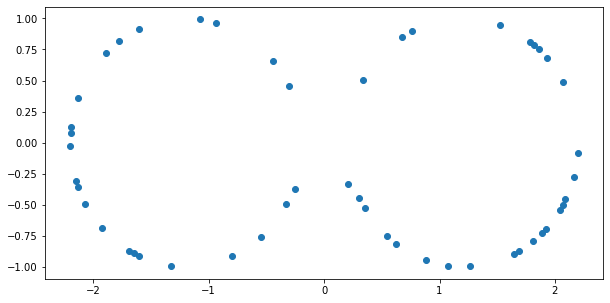

In [3]:
fig = plt.figure(figsize =(10,5))
plt.scatter(pointcloud[:,0], pointcloud[:,1])

In [5]:
S = rml.Simplex()
S.build_simplex(pointcloud, k=10, threshold_var=0.08, edge_sen=0.1)

In [6]:
def plot_graph(pointcloud, edges, inds=None, marks=None):
    fig = plt.figure(figsize =(10,5))
    plt.scatter(pointcloud[:,0], pointcloud[:,1], alpha = 0.5)

    if marks!=None:
        for k in marks:
            plt.scatter(pointcloud[k,0], pointcloud[k,1], marker='x', color='red')
            plt.text(pointcloud[k,0]+.03, pointcloud[k,1]+.03, str(k), fontsize=9)
            
    if inds==None:
        inds = list(range(len(edges)))

    for j in inds:
        for i in edges[j]:
            plt.plot([pointcloud[inds[j]][0],pointcloud[i][0]], [pointcloud[inds[j]][1],pointcloud[i][1]])

We look at the edges for the 0th point.

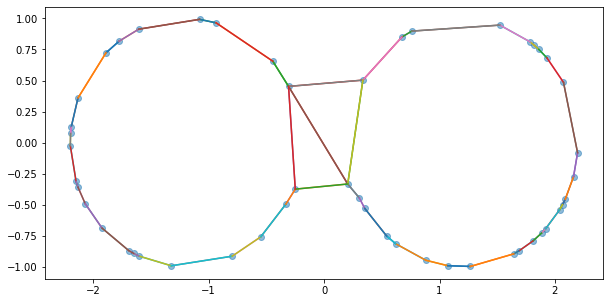

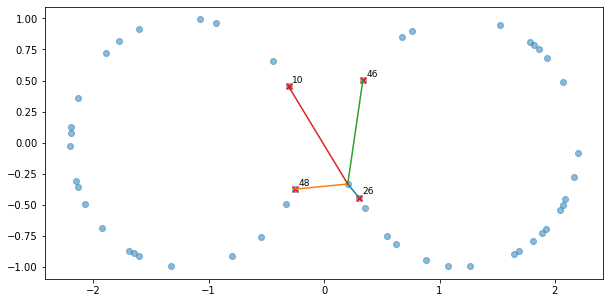

In [7]:
plot_graph(pointcloud, [S.vis[i][0]  for i in range(len(S.vis))])  # Plot of visible edges
plot_graph(pointcloud, [S.vis[i][0]  for i in [0]], [0], [26, 48, 46, 10]) # Plot of visible edges for the 0th point

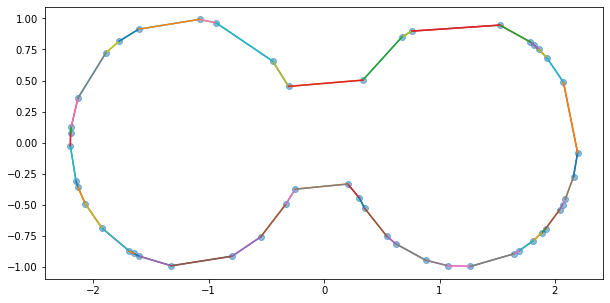

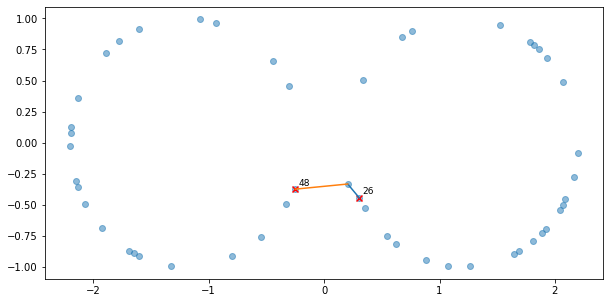

In [8]:
plot_graph(pointcloud, S.edges)  # Plot of safe edges with threshold_var=0.08, edge_sen=0.1
plot_graph(pointcloud, [S.edges[i]  for i in [0]], [0], [26, 48]) # Plot of safe edges for the 0th point

We see below that adding the extra edge to 46 (from `[26, 48]`) increases the local dimension estimated by PCA to 2 and by `edge_sen=0.1`, we discard this point as well as the others in the list which give even longer edges.

In [9]:
i = 0
print(S.vis[i])  # visible edges from the 0th point
print(S.dims[i])  # local dimension
print(S.vars[i])  # explained variance ratio from PCA when adding edges

(array([26, 48, 46, 10]), array([0.14982042, 0.45641988, 0.84706853, 0.93887795]))
[1 2]
[array([1.0000000e+00, 1.1639186e-34]), array([0.80902059, 0.19097941])]


We also see that our estimated dimension is correct.

In [18]:
print(S.dim)

1


However with different parameters, we fail to correctly identify the correct structure of the eyeglasses

In [11]:
S1 = rml.Simplex()
S1.build_simplex(pointcloud, k=10, threshold_var=0.08, edge_sen=0.3)

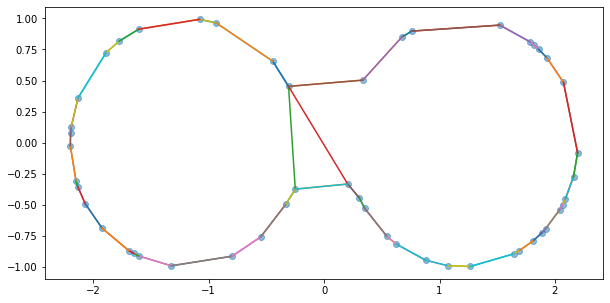

In [12]:
plot_graph(pointcloud, S1.edges)  # Plot of safe edges with threshold_var=0.08, edge_sen=0.3

This is probably less likely with more sampled points. Try it below.

In [14]:
import random
eyeglasses = np.loadtxt('eyeglasses_tight.txt')
pointcloud_120 = np.array(random.sample(list(eyeglasses), 120))

In [16]:
S2 = rml.Simplex()
S2.build_simplex(pointcloud_120, k=10, threshold_var=0.08, edge_sen=0.3)

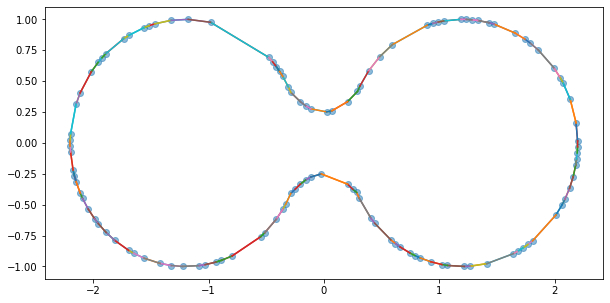

In [17]:
plot_graph(pointcloud_120, S2.edges)  # Plot of safe edges with threshold_var=0.08, edge_sen=0.2

### Swiss Roll

In [110]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
%matplotlib inline

In [111]:
swiss = tadasets.swiss_roll(n=5000, r=10)
swiss = swiss[:, [1, 2, 0]]

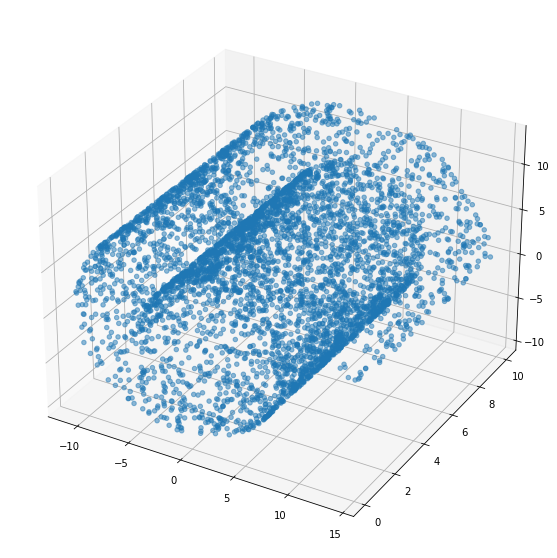

In [112]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection = '3d')
ax.scatter3D(swiss[:, 0], swiss[:, 1], swiss[:, 2], alpha=0.5)

In [128]:
S3 = rml.Simplex()
S3.build_simplex(swiss, k=15, threshold_var=0.5, edge_sen=20)

We see the dimension is correct.

In [129]:
print(S3.dim)

2


In [130]:
triangles = np.array([s[0] for s in S3.simplex.get_skeleton(2) if len(s[0]) == 3])

In [131]:
len(triangles)

2553

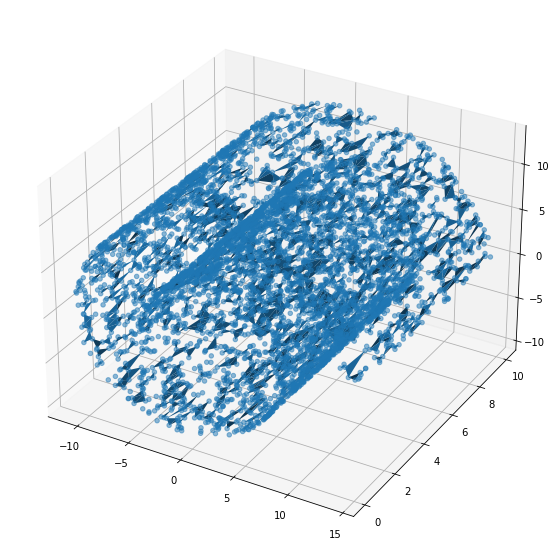

In [132]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection = '3d')
ax.scatter3D(swiss[:, 0], swiss[:, 1], swiss[:, 2], alpha=0.5)
l = ax.plot_trisurf(swiss[:, 0], swiss[:, 1], swiss[:, 2], triangles = triangles)

### N-Sphere

In [27]:
#from gudhi.datasets.generators import points
#sphere = points.sphere(1000, ambient_dim=1)
sphere = tadasets.dsphere(n=100, d=2)

In [17]:
S4 = rml.Simplex()
S4.build_simplex(sphere, k=10, threshold_var=0.08, edge_sen=1)

In [18]:
S4.dim

2

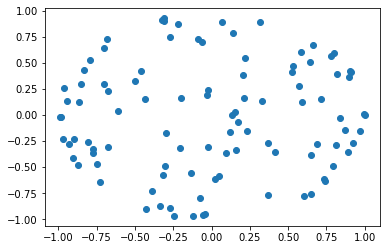

In [29]:
plt.scatter(sphere[:, 0], sphere[:, 1])

In [30]:
sphere

array([[-0.87474921, -0.47757358, -0.08208102],
       [-0.72901242, -0.64459661, -0.2302957 ],
       [-0.79481255,  0.52659446,  0.30161447],
       [-0.30325841, -0.48698111, -0.81907493],
       [ 0.78989911, -0.49302238, -0.36467565],
       [ 0.6441618 ,  0.50670559, -0.57297907],
       [ 0.3676873 , -0.76622988,  0.52697041],
       [ 0.73249428, -0.61439439,  0.29320923],
       [ 0.21717255,  0.54822978, -0.80763865],
       [ 0.88896804, -0.35711541, -0.28671312],
       [-0.27024801,  0.75284878, -0.60015392],
       [ 0.80096738,  0.59642628,  0.05222014],
       [-0.30875351,  0.90153112,  0.30317143],
       [-0.98282792, -0.02424732, -0.18292442],
       [-0.74608489, -0.472911  , -0.46873503],
       [-0.19709247,  0.1673133 ,  0.9660025 ],
       [ 0.32650224,  0.13751802,  0.93513907],
       [-0.9619194 ,  0.2597169 , -0.08519509],
       [ 0.96633114, -0.15708221, -0.2037874 ],
       [ 0.80905053, -0.2904297 ,  0.51096754],
       [-0.33644982, -0.87693954, -0.343